In [1]:
#import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))      

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data

In [70]:
PATH = '../../Dati/Run_Cs_batches_bis_Measurements_Only_5_29_2024_0001.root' #Percorso relativo del file da analizzare
#PATH = '../Dati/27_03/Run_ch4_Cs_Measurements_Only_4_21_2024_0000.root' #Percorso relativo del file da analizzare
#PATH = '../Dati/27_03/Run_ch7_Cs_Measurements_Only_3_27_2024_0000.root' #Percorso relativo del file da analizzare


RunCs = uproot.open(PATH) #Apertura file da analizzare



In [72]:
channel_idx = [0,  1, 2, 3, 4, 5, 6, 7,  8, 9,  10, 11, 12, -1, 13,14]

In [82]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'][1:-1])
ampCs = np.array(RunCs['tree'].arrays()['amp'][1:-1])




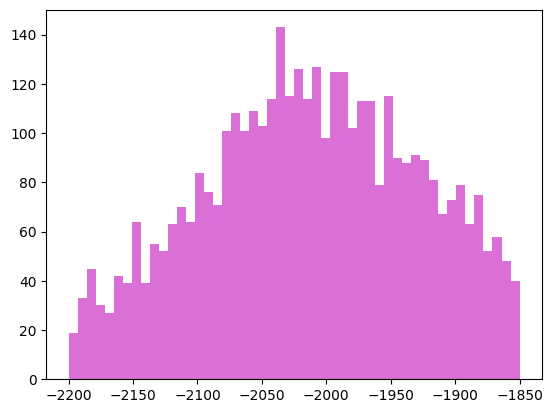

In [192]:
channel=15
lim_list = [[-700, -580],  #ch0
            [-690, -525],      #ch1      #èsbaglaito
            [-2550, -2100],  #ch2
            [-1550, -1300],  #ch3
            [-1050, -875],  #ch4
            [-1750, -1470],  #ch5
            [-1190, -1000],  #ch6
            [-1700, -1450],  #ch7
            [-1400, -1100],  #ch8
            [-750, -620],  #ch9
            [-600, -490],  #ch10
            [-970, -790],  #ch11
            [-950, -750],      #ch12
            [-3000, -100],      #ch13
            [-1600, -1300],  #ch14
            [-2200, -1850]   #ch15
            ]

bin_N, edge_N, _=plt.hist(chargeCs[:,channel_idx[channel]], range=lim_list[channel],bins=50, color='orchid')
centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


#lim_N = lim_list[channel]
#err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
#bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
#centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

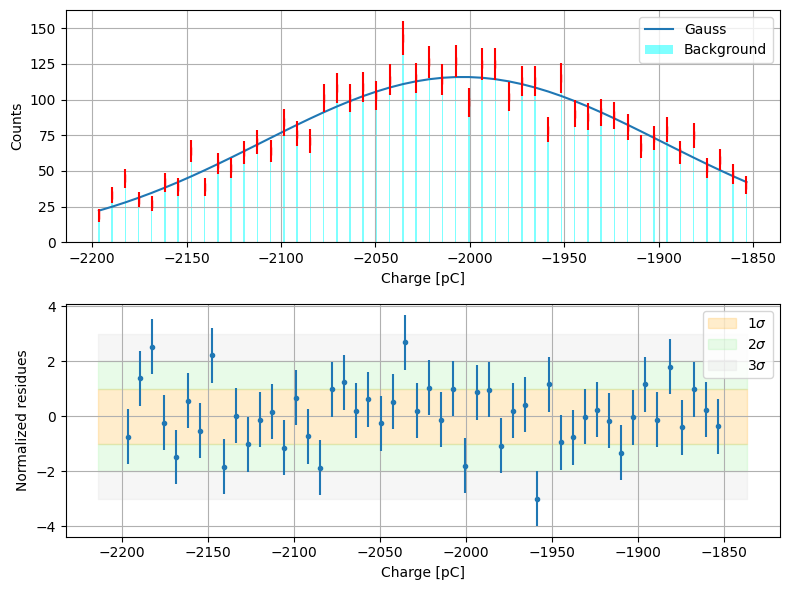

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 50
    # variables        = 3
    chi-square         = 65.4675297
    reduced chi-square = 1.39292616
    Akaike info crit   = 19.4765642
    Bayesian info crit = 25.2126333
    R-squared          = 0.89006060
[[Variables]]
    g3_amplitude:  30763.1907 +/- 674.026062 (2.19%) (init = 32550)
    g3_center:    -2003.97525 +/- 2.64695116 (0.13%) (init = -2006.587)
    g3_sigma:      105.955182 +/- 2.98107475 (2.81%) (init = 87.5)
    g3_fwhm:       249.505382 +/- 7.01989443 (2.81%) == '2.3548200*g3_sigma'
    g3_height:     115.829522 +/- 2.94947996 (2.55%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.5055
    C(g3_center, g3_sigma)     = +0.2909
    C(g3_amplitude, g3_center) = +0.2249


In [193]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

In [ ]:
peak=[ -632.216, -589.193, -2299.398]
err_peak=[0.904, 1.128, 1.476]
sigma=[39.682, 44.22,  115.395]
err_sigma=[1.075, 1.102]
